In [ ]:
! pip install sympy 1.3.0 
! pip install chempy 
! pip install schnetpack
! pip install tensorflow

ERROR: Could not find a version that satisfies the requirement 1.3.0 (from versions: none)
ERROR: No matching distribution found for 1.3.0
     |████████████████████████████████| 409kB 17.7MB/s 
     |████████████████████████████████| 92kB 13.3MB/s 
     |████████████████████████████████| 245kB 48.4MB/s 
     |████████████████████████████████| 40.6MB 1.8MB/s 
     |████████████████████████████████| 9.5MB 57.5MB/s 
     |████████████████████████████████| 430kB 53.8MB/s 
  Created wheel for chempy: filename=chempy-0.8.0-py2.py3-none-any.whl size=207570 sha256=2a69b08c405a48375b7758b86e386d25c3c563ca1148111591a3a0fb814aee0f
  Stored in directory: /root/.cache/pip/wheels/7d/52/88/f04c53d1ab0ef121e721edf910e49aa5f21a3a941d860befbf
  Created wheel for quantities: filename=quantities-0.12.4-cp37-none-any.whl size=79165 sha256=1639dd1fb81c59ef4c02636ed7364fa422c5de2962b44add810c0b112aed3264
  Stored in directory: /root/.cache/pip/wheels/2c/27/a5/62fb2a57d167d7b7164278de7399ba1504321c1d6c3a3802

     |████████████████████████████████| 266kB 17.7MB/s 
     |████████████████████████████████| 122kB 56.1MB/s 
     |████████████████████████████████| 2.2MB 47.4MB/s 


In [ ]:
import os
if not os.path.exists('./UC-MM-PBC.zip'):
    print("UC-MM-PBC.zip havent imported")
    exit()
if not os.path.exists('./UC-MM-PBC.xyz'):
    !unzip ./UC-MM-PBC.zip

UC-MM-PBC.zip havent imported
unzip:  cannot find or open ./UC-MM-PBC.zip, ./UC-MM-PBC.zip.zip or ./UC-MM-PBC.zip.ZIP.


In [ ]:
# open big file
# recognize integer in front --> go to line 1000th
# start read & write new small files
#   9989 jump each time
import re, math, os,timeit
import numpy as np
import pandas as pd
import chempy as cp 


In [ ]:
#get a file name to be read
def splitToMultiples(fileToRead, numGeomToSkip, maxGeomToRead):
  fileReader = open(fileToRead,"r",encoding='utf-8')
  line = fileReader.readline()
  NUM_COORDS = line
  
  # skip to startLine  
  startLine = numGeomToSkip * (int(NUM_COORDS.strip()) + 2) + 1
  for _ in range(startLine):
    next(fileReader)

  # start reading
  fileCount = 0
  fileWriteName = os.path.join(".", "output","geom_v2_"+str(fileCount)+".xyz")
  os.makedirs(os.path.dirname(fileWriteName), exist_ok=True) # create 'output' folder if not existed yet
  currFileWriter = open(fileWriteName,"a")
  
  while (fileCount <= maxGeomToRead):
    line = fileReader.readline()
    if re.match(' generated by VMD\n', line) : 
      continue
    elif re.match(NUM_COORDS, line):
      currFileWriter.close()
      fileCount += 1
      # creat new file --- currentFile    
      fileWriteName = os.path.join(".", "output","geom_v2_"+str(fileCount)+".xyz")
      os.makedirs(os.path.dirname(fileWriteName), exist_ok=True) # create 'output' folder if not existed yet
      currFileWriter = open(fileWriteName,"a")
      
    else:    
      # append to new file
      currFileWriter.write(line)

  currFileWriter.close()
  fileReader.close()


fileToRead = "UC-MM-PBC.xyz"
splitToMultiples(fileToRead, 100, 800)

In [ ]:
mydir = "ABS_CONFIG_0-02"
for f in os.listdir(mydir):
    if not f.endswith(".dat"):
        continue
    os.remove(os.path.join(mydir, f))

In [ ]:
mydir = "output"
# os.remove(os.path.join(mydir,".ipynb_checkpoints"))
count = 0
for f in os.listdir(mydir):
    if f == ".ipynb_checkpoints": 
        continue
    else:
    print(f)
    count += 1
print(count)    

In [ ]:
# 

In [ ]:
# configurations
# this script is applicatble only for ring-molecules
RADIUS = 0 # 6.00 angstrom -- since CoM in a couple of angstrom inside the INDOLE molecule
INDOLE_NUM_ATOM = 16
# change "header" in genGaussianInput(fileName) if use different molecule

In [ ]:
def genGaussianInput(fileName):
  '''
    take in file
    store 
    filter
      find CoM_indole
      keep looping till end of file / 3 lines at a time 
        True: write 3 lines
    close
  '''
  filePath = os.path.join(".", "output",fileName)
  print("Parsing file" + filePath)
  data = pd.read_csv(filePath, sep="\\s+", header=None)
  data[0] = data[0].apply(lambda x: cp.util.periodic.mass_from_composition(cp.util.parsing.formula_to_composition(x[0])))


  np_mass, np_x, np_y, np_z = data[0].to_numpy(dtype=np.float64), \
                                  data[1].to_numpy(dtype=np.float64), \
                                  data[2].to_numpy(dtype=np.float64), \
                                  data[3].to_numpy(dtype=np.float64)      
  #----------------------------------------------------
  start_indx = INDOLE_NUM_ATOM  
  indole_CoM = np.asarray([np.dot(np_mass[:start_indx],np_x[:start_indx])/np.sum(np_mass[:start_indx]), \
                           np.dot(np_mass[:start_indx],np_y[:start_indx])/np.sum(np_mass[:start_indx]), \
                           np.dot(np_mass[:start_indx],np_z[:start_indx])/np.sum(np_mass[:start_indx])])

  fileReader = open(filePath,"r",encoding='utf-8')

  # -------------------- start writing --------------------
  fileWriteName = os.path.join(".", "GaussInput",os.path.splitext(fileName)[0]+".inp")
  os.makedirs(os.path.dirname(fileWriteName), exist_ok=True) # create folder if not existed yet
  fileWriter = open(fileWriteName,"w+")

  # write header
  header = '{}\n{}\n{}\n\n{}\n\n{}\n'.format('%mem=1gb', 
                                                    '%nproc=1',
                                                    '#P TD(NStates=3) CAM-B3LYP/6-31G(d) SP',
                                                    'C8H7N-excited',
                                                    '0 1')      
  fileWriter.write(header)

  # read INDOLE over
  for _ in range(start_indx):
    line = fileReader.readline()
    first = line.split()[0]
    line = line.replace(first,first[0])
    fileWriter.write(line)

  # omit water ---> vibrational effects only
  # # read WATERs over
  # while start_indx < len(np_mass):
  #   '''
  #   compute CoM
  #   satisfy, write lines
  #   '''
  #   water_CoM = np.asarray([np.dot(np_mass[start_indx:start_indx+3],np_x[start_indx:start_indx+3])/np.sum(np_mass[start_indx:start_indx+3]), \
  #                           np.dot(np_mass[start_indx:start_indx+3],np_y[start_indx:start_indx+3])/np.sum(np_mass[start_indx:start_indx+3]), \
  #                           np.dot(np_mass[start_indx:start_indx+3],np_z[start_indx:start_indx+3])/np.sum(np_mass[start_indx:start_indx+3])])
  #   # ---- filter-----
  #   numline = 0
  #   if np.linalg.norm(indole_CoM - water_CoM) <= RADIUS:
  #     while numline < 3:
  #       line = fileReader.readline()
  #       first = line.split()[0]
  #       line = line.replace(first,first[0])
  #       fileWriter.write(line)
  #       numline=numline+1  
  #   else:
  #     while numline < 3:
  #       line = fileReader.readline()
  #       numline=numline+1
  #   start_indx = start_indx + 3

  fileWriter.close()
  fileReader.close()

In [ ]:
# can use multiprocessing for this
mydir = "output"
for f in os.listdir(mydir):
    if f == ".ipynb_checkpoints": 
        continue
    else:
        genGaussianInput(f)

In [ ]:
# import os
# mydir = "GaussOutput"
# for f in os.listdir(mydir):
#     if not f.endswith(".log"):
#         continue
#     os.remove(os.path.join(mydir, f))

In [ ]:
import os, os.path

# path joining version for other paths
DIR = './GaussInput'
print(len([name for name in os.listdir(DIR) if os.path.isfile(os.path.join(DIR, name))]))
# path joining version for other paths
DIR2 = './GaussOutput'
print(len([name for name in os.listdir(DIR2) if os.path.isfile(os.path.join(DIR2, name))]))

2002
2002


In [ ]:
!zip -r GaussInput.zip GaussInput/ 

In [ ]:
# cp.util.periodic.mass_from_composition(cp.util.parsing.formula_to_composition('C'))


In [ ]:
fileWriteName = os.path.join(".", "GaussInput",os.path.splitext(fileName)[0]+".inp")
fileWriteName

'./GaussInput/geom_10.inp'

In [ ]:
line1 = 'OW        23.130001       -1.129798       30.950003'
line2 = 'HW1       23.650002       -1.919798       30.630003'
first = line2.split()[0]
line2 = line2.replace(first,first[0])
line2

'H       23.650002       -1.919798       30.630003'

In [ ]:
# first = line2.split()[0]
#         line = line.replace(first,first[0])

In [ ]:
s = "hello"
print(s.capitalize())  # Capitalize a string; prints "Hello"
print(s.upper())       # Convert a string to uppercase; prints "HELLO"
print(s.rjust(7))      # Right-justify a string, padding with spaces; prints "  hello"
print(s.center(7))     # Center a string, padding with spaces; prints " hello "
print(s.replace('l', '(ell)'))  # Replace all instances of one substring with another;
                                # prints "he(ell)(ell)o"
print('  world '.strip())  # Strip leading and trailing whitespace; prints "world"

In [ ]:
'''
files are splited and jobs are executed in order
--> CAN'T USE: results must be sequential

Credit: https://www.blopig.com/blog/2016/08/processing-large-files-using-python/
'''

# import multiprocessing as mp,os

# FILENAME = "spark-sample.txt"
# def process_wrapper(chunkStart, chunkSize):
#     with open(FILENAME) as f:
#         f.seek(chunkStart)
#         lines = f.read(chunkSize).splitlines()
#         for line in lines:
#             print(line)

# def chunkify(fname,size=10):
#     fileEnd = os.path.getsize(fname)
#     with open(fname,'rb+') as f:
#       chunkEnd = f.tell() # start of file
#       while True:
#           chunkStart = chunkEnd
#           f.seek(size,1) # ---> 1 (seek relative to the current position)
#           f.readline()
#           chunkEnd = f.tell()
#           yield chunkStart, chunkEnd - chunkStart
#           if chunkEnd >= fileEnd:
#               break

# #init objects
# pool = mp.Pool(4)
# jobs = []

# #create jobs
# for chunkStart,chunkSize in chunkify(FILENAME):
#     jobs.append( pool.apply_async(process_wrapper,(chunkStart,chunkSize)) )

# #wait for all jobs to finish
# for job in jobs:
#     job.get()

# #clean up
# pool.close()

In [ ]:
def addEndline(fileName):
  '''
    take in file
    seek(end)
    add newline
    close
  '''
  f = open(fileName, 'a+')
  f.write("\n")
  f.close()

In [ ]:
# can use multiprocessing for this
def computeGauss():
  mydir = "GaussInput"
  for f in os.listdir(mydir):
    addEndline(f)

computeGauss()

In [ ]:
# import multiprocessing
# import time
# import random
# import sys
# import subprocess
# import os

# #-------------------execution for all Geom files-----------------
# # place in folder that stores "GaussInput"
# def calculate(func, args):
#     print(str(func) + str(args))
#     result = func(args)
#     return '%s says that %s%s = %s' % (
#         multiprocessing.current_process().name,
#         func.__name__, args, result
#         )

# def runGauss(inputFile):
#     # run Gaussian
#     subprocess.run(["g09", inputFile])
#     return True

# def test():
#     PROCESSES = 5
#     print('Creating pool with %d processes\n' % PROCESSES)

#     with multiprocessing.Pool(PROCESSES) as pool: # use this so dont have to close() Pool after use
#         mydir = "GaussInput"
#         TASKS = [(runGauss, f) for f in os.listdir(mydir)]
#         results = [pool.apply(calculate, t) for t in TASKS]
#         print("end script")

# if __name__ == '__main__':
#     multiprocessing.freeze_support()
#     test()

#     # --------------move to GaussOutput--------------
#     import glob
#     import shutil
#     import os
#     source_files=os.path.join(".",'*.log')
#     target_folder=os.path.join("..","..", "GaussOutput")
#     os.makedirs(target_folder,exist_ok=True)
#     # retrieve file list
#     filelist=glob.glob(source_files)
#     for single_file in filelist:
#         # move file with full paths as shutil.move() parameters
#         shutil.copy2(single_file,target_folder)

In [ ]:
mydir = "GaussOutput"
TASKS = [(runGauss, f) for f in os.listdir(mydir)]
print(len(TASKS))

1002


In [ ]:
# this goes in folder w/ GaussOut & GaussIn
import os
mydir = "GaussOutput"
mydir2 = "GaussInput"
for f in os.listdir(mydir):   # loop output
    output = (os.path.splitext(os.path.basename(f))[0])
    for f2 in os.listdir(mydir2): # loop input
        fileName = os.path.join(".",mydir2,f2)
        input = (os.path.splitext(os.path.basename(f2))[0])
        if(input==output):
            #     # --------------move to GaussOutput--------------
            import glob
            import shutil
            import os
            target_folder=os.path.join("processed")
            os.makedirs(target_folder,exist_ok=True)
            # move file with full paths as shutil.move() parameters
            shutil.move(fileName,target_folder)

In [ ]:
# move all log to Output
# check length Input & Output
# filter

In [ ]:
mydir = "GaussOutput"
mydir2 = "GaussInput"
for f in os.listdir(mydir):
    for f2 in os.listdir(mydir2):    
      if not f.endswith(".inp"):
          continue
      os.remove(os.path.join(mydir, f))

In [ ]:
!unzip ./SchNetGaussInput.zip

In [ ]:
# -------------------------- generate E & transdipole moment -----------------------------
def genSchNetInput(property_dir="GaussOutput", geom_dir="GaussInput", state=0):
    '''
      take in file (Output) 
      find matching geom (Input) 
      extract prop from Output, grab geom from Input 
      write to xyz output 1. Energy & F, 2. geom
    '''
    molecule="indole"
    method="CAM-B3LYP_6-31G_d"
    numstates = 2 
    startLine = 6 # where indole xyz coords start in Gauss .inp file
    # -------------------- open file to write --------------------
    fileWriteName = os.path.join(".", "SchNetInput","energy_dipole_S"+str(state+1)+"_"+molecule+"_"+method+".xyz")
    os.makedirs(os.path.dirname(fileWriteName), exist_ok=True) # create folder if not existed yet
    fileWriter = open(fileWriteName,"w+")

    # ----------------------------- scan for matching geoms in/output files --------------------------
    for f in os.listdir(property_dir): # loop output
        filePath1 = os.path.join(".",property_dir,f)
        geom = (os.path.splitext(os.path.basename(f))[0])
        for f2 in os.listdir(geom_dir): # loop input
            input = (os.path.splitext(os.path.basename(f2))[0])
            # --------------write to xyz--------------
            if(input==geom):
                # ------------------- extract prop from f, geom from f2 -----------------
                # read num atoms of INDOLE
                fileWriter.write(str(16)+"\n")
                # read prop over
                prop = extract_prop(filePath1)
                delim = ", "
                print(str(prop))
                # energy1, os1, dp1 = prop[state]
                # energy2, os2 = prop[state+1]

                # convert--------------------------------------------------------------------------------

                # turn result to string-------------------------------------------------------------------------------
                res = delim.join(map(str, prop[state]))
                fileWriter.write(str(res)+"\n")
                
                # read INDOLE over
                # skip first 7 lines 
                # read till end
                filePath2 = os.path.join(".",geom_dir,f2)
                fileReader2 = open(filePath2,"r",encoding='utf-8')
                line = fileReader2.readline()
                for _ in range(startLine): # skip first startLine lines
                    next(fileReader2)
                while (line != ''):
                    line = fileReader2.readline()
                    # first = line.split()[0]
                    # line = line.replace(first,first[0])
                    fileWriter.write(line)
                fileReader2.close()
    
    fileWriter.close()

genSchNetInput(state=0) # build for each state 0 / 1

In [ ]:
# ----------------------------------- generate spectrum ----------------------------------------------
import os
if not os.path.exists('./SchNetGaussInput.zip'):
    print("Please upload SchNetGaussInput.zip!")
    exit()
if not os.path.exists('./SchNetGaussInput'):
    !unzip ./SchNetGaussInput.zip

In [ ]:
# ----------------------------------- generate spectrum ----------------------------------------------
import os
if not os.path.exists('./SchNetGaussOutput.zip'):
    print("Please upload SchNetGaussOutput.zip!")
    exit()
if not os.path.exists('./SchNetGaussOutput'):
    !unzip ./SchNetGaussOutput.zip

In [ ]:
# #----------------------------------- Generate energies.data & osstr.dat -----------------------------
# import os
# mydir = "spectrumData"
# for f in os.listdir(mydir):
#     if not f.endswith(".dat"):
#         continue
#     os.remove(os.path.join(mydir, f))

In [ ]:
filePath1 = os.path.join(".","GaussOutput","geom_104.log")
def extract_prop(filePath,numstates=2):
    #return list of properties (excited-state energy, oscillator strength)
    import re
    properties = []    
    with open(filePath,'r') as f:
        count = 0
        dipole1 = None
        dipole2 = None
        for line in f:
            if (count >= numstates): 
                break
            match0 = re.match(r"^.*Ground.*to.*excited.*state.*transition.*electric.*dipole.*moments.*\(Au\):", line) # https://regex101.com/r/6Pk3E7/1
            match = re.match(r"^ Excited State.*\d:.*Singlet-A *(\d+.\d+).*eV.*\d+.\d+ nm.*f=(\d+.\d+).*<S\*\*2>=*\d+.\d+", line) # https://regex101.com/r/NILYY6/1         
            if match0:    
                next(f)
                dipoleLine1 = next(f)
                matchD1 = re.match("^ *1 *[-+]?\d+.\d+.*[-+]?\d+.\d+.*[-+]?\d+.\d+\s+[-+]?(\d+.\d+)\s+[-+]?\d+.\d+", dipoleLine1)
                dipole1 = matchD1.group(1)
                # print(dipole1)
                dipoleLine2 = next(f)
                matchD2 = re.match("^ *2 *[-+]?\d+.\d+\s+[-+]?\d+.\d+\s+[-+]?\d+.\d+\s+[-+]?(\d+.\d+) .*\d+.\d+", dipoleLine2)
                # print(dipoleLine2)
                dipole2 = matchD2.group(1)
                # print(dipole2)
            if match:
                energy = match.group(1)
                oscil_strength = match.group(2)
                if (count==0):  properties.append((energy, oscil_strength,dipole1))
                if (count==1):  properties.append((energy, oscil_strength,dipole2))
                count = count + 1

    properties.append(filePath)
    return properties 
prop = extract_prop(filePath1)
print(prop)

[('4.9832', '0.0449', '0.3676'), ('5.2067', '0.1372', '1.0752'), './GaussOutput/geom_104.log']


In [ ]:
# count geometries in file xyz 
file = open(os.path.join("SchNetInput","energy_dipole_S1_indole_CAM-B3LYP_6-31G_d.xyz"), "r")
line_count = 0
for line in file:
    if line != "\n":
        line_count += 1
file.close()

print(line_count/18)

2002.0


In [ ]:
from schnetpack.data.atoms import AtomsData
from ase.io import read
import numpy as np
import schnetpack as spk
import os

In [ ]:
# comment line is weirdly stored in the info dictionary as key by ASE. here it corresponds to the energy
atoms = read(os.path.join("SchNetInput","energy_dipole_S1_indole_CAM-B3LYP_6-31G_d.xyz"), index=':')
print(len(atoms))
print('Energy:', atoms[0].info)
print()
properties = ['energy', 'oscil_strength', 'dipole_moment']

# %rm './SchNet_S2.db'
new_dataset = AtomsData('./SchNet_energy_dipole_S1.db', available_properties=properties)

# parse properties as list of dictionaries
# energy_list = []
# dipole_moment]
for at in atoms:
    # All properties need to be stored as numpy arrays.
    # Note: The shape for scalars should be (1,), not ()
    # Note: GPUs work best with float32 data
    energy = np.array([float(list(at.info.keys())[0].replace(',', ''))], dtype=np.float32)
    oscil_strength = np.array([float(list(at.info.keys())[1].replace(',', ''))], dtype=np.float32)
    dipole_moment = np.array([float(list(at.info.keys())[2])], dtype=np.float32)

    new_dataset.add_system(at,energy=energy, oscil_strength=oscil_strength, dipole_moment=dipole_moment)

2002
Energy: {'4.9204,': True, '0.1511,': True, '1.2531': True}



In [ ]:
print('Number of reference calculations:', len(new_dataset))
print('Available properties:')

for p in new_dataset.available_properties:
    print('-', p)
print()

example = new_dataset[0]
print('Properties of molecule with id 0:')

for k, v in example.items():
    print('-', k, ':', v.shape)

Number of reference calculations: 2002
Available properties:
- energy
- oscil_strength
- dipole_moment

Properties of molecule with id 0:
- energy : torch.Size([1])
- oscil_strength : torch.Size([1])
- dipole_moment : torch.Size([1])
- _atomic_numbers : torch.Size([16])
- _positions : torch.Size([16, 3])
- _cell : torch.Size([3, 3])
- _neighbors : torch.Size([16, 15])
- _cell_offset : torch.Size([16, 15, 3])
- _idx : torch.Size([1])


/usr/local/lib/python3.7/dist-packages/ase/atoms.py:968: VisibleDeprecationWarning: Use get_global_number_of_atoms() instead
  np.VisibleDeprecationWarning)


In [ ]:
# ----------------------------- Gen spectrum data --------------------------
def genEnergyAndOscil(property_dir="GaussOutput"):
    '''
      take in file (Output) 
      find matching geom (Input) 
      extract prop from Output, grab geom from Input 
      write to xyz output 1. Energy & F, 2. geom
    '''
    # -------------------- open file to write --------------------
    fileWriteName = os.path.join(".", "spectrumData","energies.dat")
    os.makedirs(os.path.dirname(fileWriteName), exist_ok=True) # create folder if not existed yet
    fileWriter = open(fileWriteName,"w+")

    fileWriteName2 = os.path.join(".", "spectrumData","oscst.dat")
    os.makedirs(os.path.dirname(fileWriteName2), exist_ok=True) # create folder if not existed yet
    fileWriter2 = open(fileWriteName2,"w+")

    # ----------------------------- scan for matching geoms in/output files --------------------------
    for f in os.listdir(property_dir): # loop output
        filePath1 = os.path.join(".",property_dir,f)
        # ------------------- extract prop from f, geom from f2 -----------------
        # read prop over
        prop = extract_prop(filePath1)
        delim = ", "
        print(str(prop))
        energy1, os1 = prop[0]
        energy2, os2 = prop[1]
        # energy2, os2 = prop[1]
        # res = delim.join(map(str, prop[state]))
        fileWriter.write(str(energy1)+" "+str(energy2)+"\n")
        fileWriter2.write(str(os1)+" "+str(os2)+"\n")
    
    fileWriter.close()
    fileWriter2.close()

genEnergyAndOscil() # build for each state 0 / 1

In [ ]:
!unzip ./SchNetModel2_energy_oscil_dipole_128_10_5p.zip

Archive:  ./SchNetModel2_energy_oscil_dipole_128_10_5p.zip
  inflating: SchNetModel2/best_model  
replace SchNetModel2/split.npz? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: SchNetModel2/split.npz  
   creating: SchNetModel2/tensorboard/
  inflating: SchNetModel2/tensorboard/events.out.tfevents.1619748028.f1c772c8c9e5  
  inflating: SchNetModel2/tensorboard/events.out.tfevents.1619750940.f1c772c8c9e5  
  inflating: SchNetModel2/tensorboard/events.out.tfevents.1619754055.f1c772c8c9e5  
   creating: SchNetModel2/checkpoints/
  inflating: SchNetModel2/checkpoints/checkpoint-2060.pth.tar  
  inflating: SchNetModel2/checkpoints/checkpoint-2070.pth.tar  
  inflating: SchNetModel2/checkpoints/checkpoint-2080.pth.tar  
  inflating: SchNetModel2/SchNet_energy_oscil_dipole_S2.db  
  inflating: SchNetModel2/log.csv    


In [ ]:
%rm -rf ./SchNetModel2/checkpoints
%rm -rf ./SchNetModel2/log.csv
%rm -rf ./SchNetModel2/best_model
%rm -rf ./SchNetModel2/tensorboard

Archive:  ./SchNetModel1_energy_oscil_dipole_128_10_5p.zip
replace SchNetModel2/best_model? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: SchNetModel2/best_model  
  inflating: SchNetModel2/split.npz  
  inflating: SchNetModel2/SchNet_energy_oscil_dipole_S1.db  
 extracting: SchNetModel2/tensorboard/events.out.tfevents.1619758161.f4e55e85ca12  
 extracting: SchNetModel2/tensorboard/events.out.tfevents.1619758306.f4e55e85ca12  
 extracting: SchNetModel2/tensorboard/events.out.tfevents.1619758241.f4e55e85ca12  
  inflating: SchNetModel2/tensorboard/events.out.tfevents.1619758311.f4e55e85ca12  
 extracting: SchNetModel2/tensorboard/events.out.tfevents.1619758260.f4e55e85ca12  
  inflating: SchNetModel2/tensorboard/events.out.tfevents.1619764743.f4e55e85ca12  
  inflating: SchNetModel2/checkpoints/checkpoint-2410.pth.tar  
  inflating: SchNetModel2/checkpoints/checkpoint-2420.pth.tar  
  inflating: SchNetModel2/checkpoints/checkpoint-2400.pth.tar  
  inflating: SchNetModel2/log.csv 

/usr/local/lib/python3.7/dist-packages/ase/atoms.py:968: VisibleDeprecationWarning: Use get_global_number_of_atoms() instead
  np.VisibleDeprecationWarning)


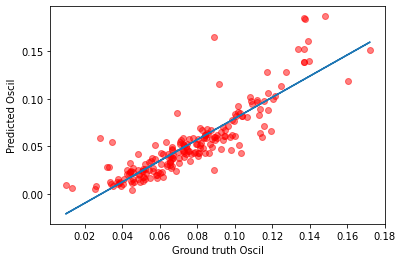

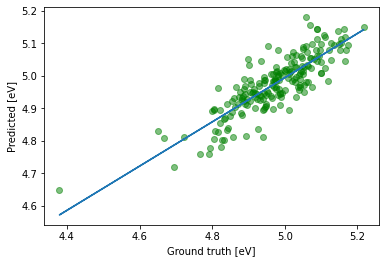

No handles with labels found to put in legend.


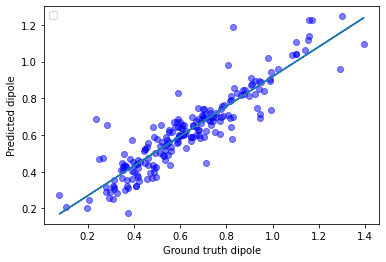

Mean S2 energy / atom     :       4.9714 [eV]
Std. dev. S2 energy / atom:       0.1117 [ev]
Mean dipole / atom        :       0.0764 []
Std. dev.  dipole / atom  :       0.0289 []
Mean dipole / atom        :       0.6290 []
Std. dev.  dipole / atom  :       0.2419 []

Test MAE:
    energy     :      0.046 eV
    WMAPError  :      0.928 %
    oscil      :      0.027
    WMAPError  :     35.381 %
    dipole     :      0.071
    WMAPError  :     11.215 %


In [ ]:
!unzip ./SchNetModel1_energy_oscil_dipole_128_10_5p.zip

import torch
import matplotlib.pyplot as plt
import numpy as np
import schnetpack as spk
import os
from schnetpack.data.atoms import AtomsData

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
properties = ['energy', 'oscil_strength', 'dipole_moment']
SchNetModel = './SchNetModel2'
SchNet_data = AtomsData(os.path.join('.','SchNetModel2','SchNet_energy_oscil_dipole_S1.db'), available_properties=properties)    
best_model = torch.load(os.path.join(SchNetModel, 'best_model'))

train, val, test = spk.train_test_split(
    data=SchNet_data,
    num_train=1500,
    num_val=300,
    split_file=os.path.join(SchNetModel, "split.npz"),
)
train_loader = spk.AtomsLoader(train, batch_size=100, shuffle=True)
val_loader = spk.AtomsLoader(val, batch_size=100)
test_loader = spk.AtomsLoader(test, batch_size=100)

means, stddevs = test_loader.get_statistics(
    properties
)

energy_error = 0.0
oscil_error = 0.0
dipole_error = 0.0

final_batch = None
final_pred = None
final_batchD = None
final_predD = None
final_batchOs = None
final_predOs = None
for count, batch in enumerate(test_loader):
    # move batch to GPU, if necessary
    batch = {k: v.to(device) for k, v in batch.items()}

    # apply model
    pred = best_model(batch)
    temp0 = batch 
    temp_pred0 = pred
    temp = temp0['energy'].detach().cpu().numpy()
    temp_pred = temp_pred0['energy'].detach().cpu().numpy()
    #--------------------------- dipole --------------------------
    tempD = temp0['dipole_moment'].detach().cpu().numpy()
    temp_predD = temp_pred0['dipole_moment'].detach().cpu().numpy()

    # calculate absolute error of energies
    tmp_energy = torch.sum(torch.abs(pred['energy'] - batch['energy']))
    tmp_energy = tmp_energy.detach().cpu().numpy() # detach from graph & convert to numpy
    energy_error += tmp_energy

    # absolute error for dipole
    tmp_dipole = torch.sum(torch.abs(pred['dipole_moment'] - batch['dipole_moment']))
    tmp_dipole = tmp_dipole.detach().cpu().numpy()
    dipole_error += tmp_dipole

    # ---- log to CSV file -------
    if final_batch is None:
        final_batch = temp.copy()
    else:
        final_batch = np.concatenate((final_batch,temp),axis=None)

    if final_pred is None:
        final_pred = temp_pred.copy()
    else:
        final_pred = np.concatenate((final_pred,temp_pred),axis=None)
    
    #------------------------------------------------------------------
    if final_batchD is None:
        final_batchD = tempD.copy()
    else:
        final_batchD = np.concatenate((final_batchD,tempD),axis=None)

    if final_predD is None:
        final_predD = temp_predD.copy()
    else:
        final_predD = np.concatenate((final_predD,temp_predD),axis=None)

    #------------------------------ Oscil strength ---------------------------
    tmpO = temp0['oscil_strength'].detach().cpu().numpy()
    tmp_oscil = np.sum(np.abs(getOscil(temp_pred,temp_predD)-tmpO))
    oscil_error += tmp_oscil

    if final_batchOs is None:
        final_batchOs = tmpO.copy()
    else:
        final_batchOs = np.concatenate((final_batchOs,tmpO),axis=None)

final_predOs = getOscil(final_pred,final_predD)

plt.scatter(final_batchOs, final_predOs, c="r", alpha=0.5)
plt.xlabel("Ground truth Oscil")
plt.ylabel("Predicted Oscil")
# plt.legend(loc='upper left')

m, b = np.polyfit(final_batchOs, final_predOs, 1)
plt.plot(final_batchOs, m*final_batchOs + b)
plt.show()



plt.scatter(final_batch, final_pred, c="g", alpha=0.5)
plt.xlabel("Ground truth [eV]")
plt.ylabel("Predicted [eV]")
# plt.legend(loc='upper left')

m, b = np.polyfit(final_batch, final_pred, 1)
plt.plot(final_batch, m*final_batch + b)
plt.show()


plt.scatter(final_batchD, final_predD, c="b", alpha=0.5)
plt.xlabel("Ground truth dipole")
plt.ylabel("Predicted dipole")
plt.legend(loc='upper left')

mD, bD = np.polyfit(final_batchD, final_predD, 1)
plt.plot(final_batchD, mD*final_batchD + bD)
plt.show()


np.savetxt('E1_batch_1500_300.csv', final_batch[100:150])
np.savetxt('E1_pred_1500_300.csv', final_pred[100:150])
np.savetxt('oscil1_batch_1500_300.csv', final_batchOs[100:150])
np.savetxt('oscil1_pred_1500_300.csv', final_predOs[100:150])

energy_error /= len(test)
energy_error_percentage = energy_error *100 / means['energy'][0]

oscil_error /= len(test)
oscil_error_percentage = oscil_error *100 / means['oscil_strength'][0]

dipole_error /= len(test)
dipole_error_percentage = dipole_error *100 / means['dipole_moment'][0]

print('Mean S2 energy / atom     : {:12.4f} [eV]'.format(means['energy'][0]))
print('Std. dev. S2 energy / atom: {:12.4f} [ev]'.format(stddevs['energy'][0]))
print('Mean dipole / atom        : {:12.4f} []'.format(means['oscil_strength'][0]))
print('Std. dev.  dipole / atom  : {:12.4f} []'.format(stddevs['oscil_strength'][0]))
print('Mean dipole / atom        : {:12.4f} []'.format(means['dipole_moment'][0]))
print('Std. dev.  dipole / atom  : {:12.4f} []'.format(stddevs['dipole_moment'][0]))

print('\nTest MAE:')
print('    energy     : {:10.3f} eV'.format(energy_error))
print('    WMAPError  : {:10.3f} %'.format(energy_error_percentage))
print('    oscil      : {:10.3f}'.format(oscil_error))
print('    WMAPError  : {:10.3f} %'.format(oscil_error_percentage))
print('    dipole     : {:10.3f}'.format(dipole_error))
print('    WMAPError  : {:10.3f} %'.format(dipole_error_percentage))



In [ ]:
def getOscil(energy,dipole):#0.02449
    return np.multiply(np.multiply(0.025,energy),np.square(dipole))

a = np.array([[2], 
              [3], 
              [5]])
b = np.array([[5], 
              [4], 
              [100]])
getOscil(a,b)
# np.apply_along_axis(my_func, 1, b)
# array([2.,  5.,  8.])
np.abs(a-b)

array([[ 3],
       [ 1],
       [95]])

In [ ]:
# ---------------------- script for drawing spectrum ---------------------- 
mydir = "ABS_CONFIG_0-02"
for f in os.listdir(mydir):
    if not f.endswith(".dat"):
        continue
    os.remove(os.path.join(mydir, f))

In [ ]:
!unzip ABS_CONFIG_0-18.zip

Archive:  ABS_CONFIG_0-18.zip
   creating: ABS_CONFIG_0-02/
  inflating: ABS_CONFIG_0-02/CONFIG_3.dat  
  inflating: ABS_CONFIG_0-02/CONFIG_39.dat  
  inflating: ABS_CONFIG_0-02/CONFIG_5.dat  
  inflating: ABS_CONFIG_0-02/CONFIG_30.dat  
  inflating: ABS_CONFIG_0-02/CONFIG_15.dat  
  inflating: ABS_CONFIG_0-02/CONFIG_12.dat  
  inflating: ABS_CONFIG_0-02/CONFIG_17.dat  
  inflating: ABS_CONFIG_0-02/CONFIG_6.dat  
  inflating: ABS_CONFIG_0-02/CONFIG_43.dat  
  inflating: ABS_CONFIG_0-02/CONFIG_13.dat  
  inflating: ABS_CONFIG_0-02/CONFIG_27.dat  
  inflating: ABS_CONFIG_0-02/CONFIG_4.dat  
  inflating: ABS_CONFIG_0-02/CONFIG_32.dat  
  inflating: ABS_CONFIG_0-02/CONFIG_34.dat  
  inflating: ABS_CONFIG_0-02/CONFIG_8.dat  
  inflating: ABS_CONFIG_0-02/CONFIG_47.dat  
  inflating: ABS_CONFIG_0-02/CONFIG_44.dat  
  inflating: ABS_CONFIG_0-02/CONFIG_49.dat  
  inflating: ABS_CONFIG_0-02/CONFIG_20.dat  
  inflating: ABS_CONFIG_0-02/CONFIG_1.dat  
  inflating: ABS_CONFIG_0-02/CONFIG_19.dat  
 

In [ ]:
# ^ *(\d+.\d+) *(\d+.\d+)

import pandas as pd
import os
import numpy as np
abs_folder = "ABS_CONFIG_0-02"
final_df = None
for fileN in os.listdir(abs_folder):
    df = pd.read_csv(os.path.join(abs_folder,fileN), header = None, sep ='\s+',engine = 'python')  
    #Convert to numeric
    for col in df:
        df[col] = pd.to_numeric(df[col])
    if final_df is None:
        final_df = df.copy()
    else:
        # final_df[0] = final_df[2]+df[2] 
        final_df[1] = final_df[1]+df[1] 

# Create an object to transform the data to fit minmax processor
# final_df[1] = min_max_scaler.fit_transform(final_df[1])
final_df[1]=(final_df[1]-final_df[1].min())/(final_df[1].max()-final_df[1].min())

# # Run the normalizer on the dataframe
# df_normalized = pd.DataFrame(y_scaled)
np.savetxt(os.path.join(".",abs_folder,"spectrum.txt"), final_df, fmt='%16.4e' , newline="\r\n")

In [ ]:
results = np.loadtxt(os.path.join(".",abs_folder,"spectrum.txt"))
results

array([[4.0000e+00, 0.0000e+00],
       [4.0020e+00, 7.1955e-05],
       [4.0040e+00, 1.4447e-04],
       ...,
       [5.9960e+00, 3.2625e-03],
       [5.9980e+00, 3.1748e-03],
       [6.0000e+00, 3.0877e-03]])

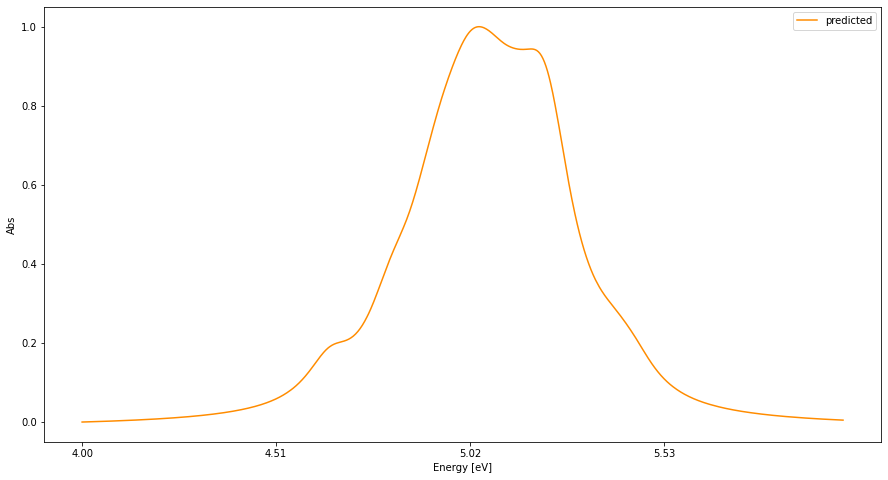

In [ ]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
results = np.loadtxt(os.path.join(".",abs_folder,"spectrum.txt"))
results2 = np.loadtxt(os.path.join(".",abs_folder,"spectrum_pred.txt"))

time = results[:,0]
train_loss = results[:,1]
time2 = results2[:,0]
train_loss2 = results2[:,1]


plt.figure(figsize=(15,8))
# plt.subplot(1,2,1)
# plt.plot(time, val_loss, label='Validation')
# plt.plot(time, train_loss, label='truth-value')
plt.plot(time2, train_loss2, label='predicted',c='darkorange')
# plt.yscale('log')
plt.ylabel('Abs')
plt.xlabel('Energy [eV]')
plt.xticks(np.arange(min(time), max(time), 0.51))
plt.legend()
plt.show()

In [ ]:
# 